# Preprocessing using scycle to OT plots

In [1]:
import numpy as np
import pandas as pd
import scvelo as sv
import anndata
import scanpy as sc
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import scycle as sy

from scipy import stats

mpl.rcParams['figure.dpi'] = 70

from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize

from sklearn.neighbors import NearestNeighbors

import os
os.environ['R_HOME'] = '/usr/lib/R'
import rpy2.robjects as ro

import sys
DATA_PATH = '/home/risitop/OneDrive/Documents/PHD/y1/data/CCLE/'
sys.path.append(DATA_PATH)
plt.style.use('dark_background')

## Preprocessing, pooling

In [2]:
# We start from CPM_data.h5ad, which contains CPM_data.txt + Metadata.txt annotations
adata = sc.read_h5ad(DATA_PATH + 'CPM_data.h5ad')
adata

AnnData object with n_obs × n_vars = 53513 × 22722
    obs: 'Cell_line', 'Cancer_type'

In [3]:
# We preprocess data cell line per cell line using scycle
# and default parameters.
# We store data in $DATA_PATH/pp/ directory.
for cl in set(adata.obs['Cell_line']):
    adata_cl = adata[adata.obs['Cell_line'] == cl,:].copy()    
    if adata_cl.n_obs < 100: # Only keeping cell lines with >100 cells
        continue        
    print("-- Preprocessing %s..." % cl + " "*100, end="\r")
    sy.pp.prep_pooling(adata_cl, division_factor=50, verbose=False)
    adata_cl.write("%spp/%s_pp.h5ad" % (DATA_PATH, cl))

## IC projection

In [4]:
# We load gene weights from S matrix, computed with JHU011
df_gene_weights = pd.read_csv(DATA_PATH + 'JHU011_UPPER_AERODIGESTIVE_TRACT_ica_S.xls', sep='\t', index_col=0)
df_gene_weights

,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,Unnamed: 16
PROBE,,,,,,,,,,,,,,,,
CDK1,-0.9190,5.0419,8.2869,-0.9463,0.5935,-0.0419,0.0775,-1.5286,-1.7286,8.2389,-1.3952,0.6260,-0.3849,0.8650,-0.8569,NaN
UBE2C,0.6697,3.1003,9.5936,-1.6848,-1.2334,-0.0712,-0.1914,4.6683,-0.5717,4.0906,-0.4803,1.1264,-0.3727,0.8197,-0.8002,NaN
CCNB1,-0.4128,-3.9112,11.4137,0.4421,1.2527,1.1820,-1.3029,6.0085,-1.2580,0.3552,-0.9335,0.2340,1.4414,0.2826,3.3749,NaN
AURKB,-1.3091,4.9938,8.9267,-0.5047,1.0750,0.2742,0.9673,3.2298,-0.3919,4.0472,-2.2181,-1.2844,-0.6276,0.5016,0.7448,NaN
AURKA,-0.1496,-2.8967,11.9240,0.1731,0.9337,0.2881,0.4520,-0.9910,0.2682,-0.3779,0.3459,0.6775,1.6482,0.4719,3.1775,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LGALS3,-0.1466,-0.9214,-0.0991,-0.6781,-0.1304,-1.3243,1.0802,0.2069,-0.8436,0.8988,-1.2667,1.4437,0.0509,0.4350,0.8060,NaN
DOK1,0.4799,0.1539,-0.3843,-0.4367,-0.2834,-0.4136,0.1613,-0.0583,0.2711,-0.1829,-0.7776,-0.4143,0.2355,0.1569,-0.1020,NaN
MVB12A,-0.6149,-0.3588,-0.5584,-0.6734,1.2381,0.1803,0.2249,-0.0821,-0.0896,0.5334,0.3950,-0.5984,0.1611,-1.5826,-1.0250,NaN


In [5]:
# Allows for batch matrix computation (for memory savings,
# relevant when dealing with large matrices)
def batch_computation(X, f, k=10, verbose=False):
    n = len(X)
    step = int(n/k)
    X_tot = None
    for i in range(k+1):
        if verbose: print('Computing batch %i...' % (i + 1))
        X_batch = f(X[i*step:(i+1)*step,:])
        if X_tot is None:
            X_tot = X_batch
        else:
            X_tot = np.vstack( (X_tot, X_batch) )
    return X_tot

def compute_ICs(adata, df_S):
    
    def one_step(X): # ICA projection
        X = np.log(X + 1)
        X = X - X.mean(axis=0)
        return X@df_S.values[:,:-1]
    
    IC_genes = [g for g in list(df_S.index) if g in adata.var_names]
    df_S = df_S.loc[IC_genes,:]
    adata_red = adata[:,IC_genes]
    X_ICs = batch_computation(adata_red.X, one_step, k=1)
    
    return pd.DataFrame(
        data=X_ICs, 
        index=adata.obs_names.str.decode('utf-8'), 
        columns=['IC%i' % (i+1) for i in range(len(X_ICs.T))]
    )

In [6]:
import os

df_total = None

# For every preprocessed cell_line file, project it
for filename in os.listdir(DATA_PATH + 'pp/'):
    adata = sc.read_h5ad(DATA_PATH + 'pp/%s' % filename)
    df = compute_ICs(adata, df_gene_weights) # projection
    df['Cell_line'] = list(adata.obs['Cell_line'])
    df['Cells'] = list(adata.obs_names)
    df = df.set_index('Cells')
    # Concatenation in one big DF
    if df_total is None:
        df_total = df
    else:
        df_total = pd.concat( [df_total, df] )
        print("Appended %i cells from %s." % (len(df), filename) + " "*30, end="\r")

df_total.to_csv(DATA_PATH + 'pp_ics/all_cancertypes_ics.csv')
df_total

,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,Cell_line
Cells,,,,,,,,,,,,,,,,
AACCGCGCATCGGAAG-15-19,-2.896900,3.162428,-107.042184,-12.810341,-45.435697,-15.196322,58.716250,-55.275761,30.615555,27.835609,-12.473310,-3.990857,-5.739086,2.483698,5.023440,TE14_OESOPHAGUS
AACCGCGGTACTCGCG-15-19,1.873398,6.953651,-124.282416,-61.293999,-51.936824,17.478231,35.045031,-32.495866,10.410580,26.439930,-17.774251,-1.557083,-34.790737,2.252855,-7.129675,TE14_OESOPHAGUS
AACCGCGGTCTCAACA-15-19,-20.774356,-5.438524,48.458600,-16.099387,-18.285324,0.296678,6.164442,3.336404,2.374895,42.673280,-7.640419,-7.927433,-15.811313,6.131749,-9.721371,TE14_OESOPHAGUS
AACTGGTAGACCTAGG-15-19,-43.972802,-8.722353,-61.182838,-85.531792,-65.140863,21.851150,28.544445,-4.553470,15.310288,32.471579,-31.888349,-1.156344,-35.106315,5.492143,3.581847,TE14_OESOPHAGUS
AACTTTCCAGTACACT-15-19,1.928511,-18.530290,93.166270,37.431606,14.401141,-2.898313,-7.461924,29.784241,9.126007,-67.281693,22.287338,5.917641,18.573669,20.570285,11.266379,TE14_OESOPHAGUS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCCCAGTCCTAGTGA-8-16,3.460123,-63.246079,-147.119346,-2.332580,-0.152907,10.950284,-32.180619,-6.885579,-3.322939,-41.117783,-17.877602,-9.004962,16.211496,-20.493401,-6.884220,MDAMB361_BREAST
TTCTCAAAGTACATGA-8-16,22.239571,-4.164592,136.267696,27.501201,7.473315,1.960224,-31.653175,91.666390,8.500576,-24.174697,2.622286,-0.070499,29.520188,4.648659,15.790313,MDAMB361_BREAST
TTCTCAACAGTTAACC-8-16,13.677909,99.441855,198.588623,16.012815,-38.803697,-5.337103,13.974260,42.110153,14.757123,61.180685,-12.553105,-9.083456,-9.748062,14.551603,15.362176,MDAMB361_BREAST


## OT transfer

In [7]:
import ot

from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

# Basic OT functions, for different flavors
def compute_discrepancy_nn(Xs, Xt, n_neighbors=3):
    nns = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(Xs).kneighbors_graph(Xs).toarray()
    nnt = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(Xt).kneighbors_graph(Xt).toarray()
    D = nnt - nns
    return np.linalg.norm(D, axis=0).astype(float)/n_neighbors

def cosine_pairwise_distance(X):        
    n = np.linalg.norm(X, axis=1)
    X = np.dot(np.diag(1/n), X)
    return cdist(X, X)

def compute_discrepancy_d(Xs, Xt):
    Ds = cosine_pairwise_distance(Xs)
    Dt = cosine_pairwise_distance(Xt)
    D = Ds - Dt
    return 1 / np.linalg.norm(D, axis=1)
    
def OT_raw(Xs, Yt, alph=1, bet=1, f=lambda x: x):
    w_x, w_y = np.ones((len(Xs),))/len(Xs), np.ones((len(Yt),))/len(Yt)
    M = ot.dist(Xs, Yt)**alph
    M /= M.max()
    Gs = f(ot.sinkhorn(w_x, w_y, M, 1e-3))
    return np.dot(np.diag(1/w_x), np.dot(Gs, Yt))

def OT_regularized_nn(Xs, Yt, alph=1, bet=1, n_neighbors=3):
    Xt = OT_raw(Xs, Yt, alph, bet)
    lambdas = 1 - compute_discrepancy_nn(Xs, Xt, n_neighbors)
    return np.dot(np.diag(lambdas), Xt - Xs) + Xs

def OT_regularized_d(Xs, Yt, alph=1, bet=1):
    Xt = OT_raw(Xs, Yt, alph, bet)
    lambdas = 1 - compute_discrepancy_d(Xs, Xt)
    return np.dot(np.diag(lambdas), Xt - Xs) + Xs

def OT_oob(Xs, Yt, alph=1, bet=1, n_neighbors=3):
    n = len(Xs)
    Xt = OT_raw(Xs, Yt, alph, bet)
    lambdas = compute_discrepancy_nn(Xs, Xt, n_neighbors)
    return np.hstack((Xt, np.reshape(lambdas, (n, 1))))

def to_numpy(df, cols, cell_line=None):
    target_X = df[cols].values
    if cell_line is not None:
        target_X = target_X[df['Cell_line'].str.contains(cell_line)]
    return target_X

In [8]:
# JHU011 extraction, target dataset
ics = ['IC%i' % i for i in (2, 3, 8, 10)]
target_X = to_numpy(df_total, ics, 'JHU011')

In [9]:
# Collecting all sources datasets
Xs_before = []
labels = []
n = len(set(df_total['Cell_line']))
for i, cl in enumerate(set(df_total['Cell_line'])):
    source_X = to_numpy(df_total, ics, cl)
    if 'JHU011' in cl:
        continue
    print( ('[%i/%i] Retrieving cell line %s...' % (i+1, n, cl)) + ' '*30, end='\r')
    Xs_before.append(source_X)
    labels.append(cl)
print('\n-- %i cell lines retrieved.' % len(labels))

[183/183] Retrieving cell line LNCAPCLONEFGC_PROSTATE...                                           
-- 182 cell lines retrieved.


In [10]:
# Computing OT in different flavors
Xs_raw = []
Xs_regularized_nn = []
Xs_regularized_d = []
n = len(set(df_total['Cell_line']))
for i, (X, l) in enumerate(zip(Xs_before, labels)):
    print( ('[%i/%i] Transporting cell line %s...' % (i+1, n, cl)) + ' '*30, end='\r')
    Xs_raw.append(OT_raw(X, target_X))
    Xs_regularized_nn.append(OT_regularized_nn(X, target_X, n_neighbors=10))
    Xs_regularized_d.append(OT_regularized_d(X, target_X))

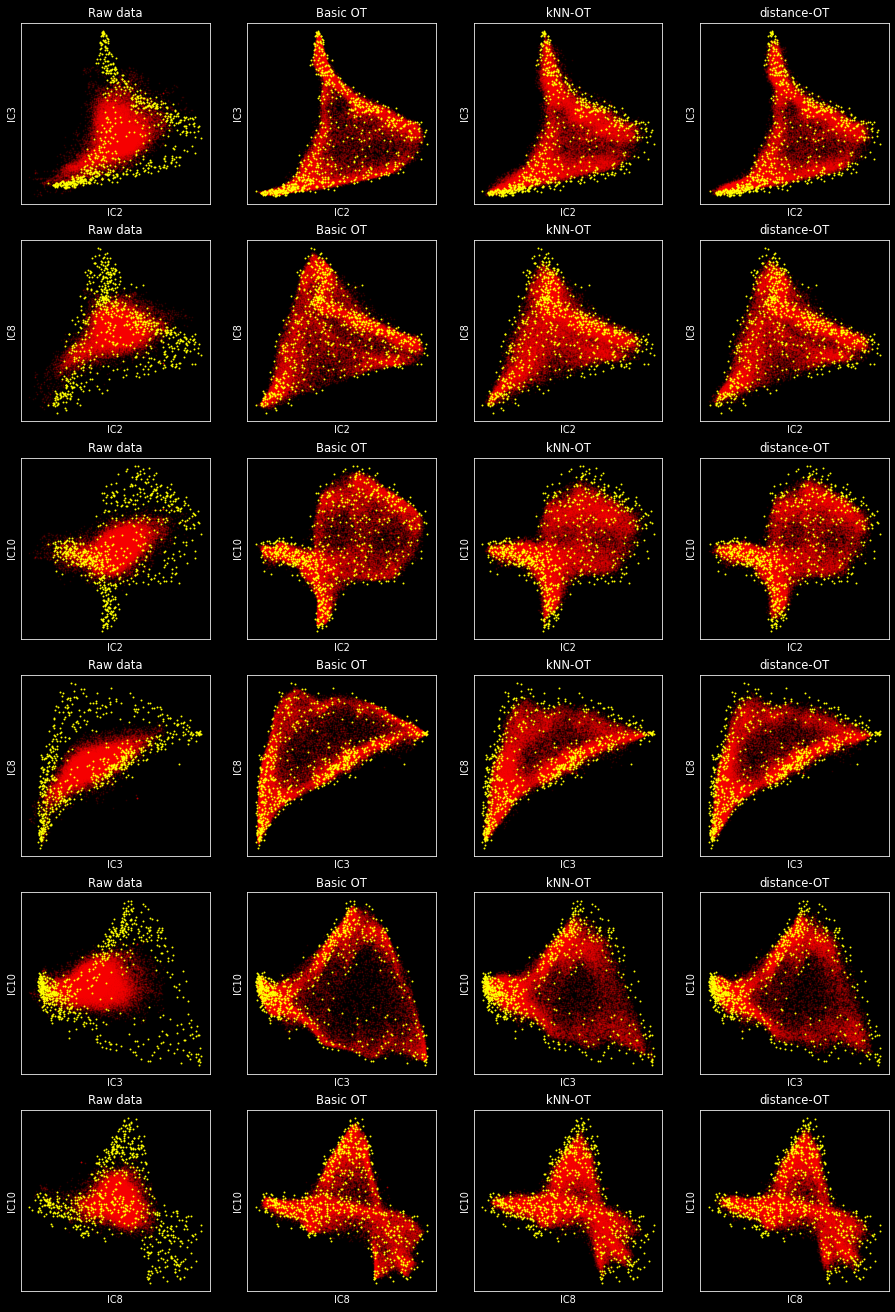

In [11]:
# Plotting

def find_pcs(k):
    if k == 0:
        return 0, 1
    if k == 1:
        return 0, 2
    if k == 2:
        return 0, 3
    if k == 3:
        return 1, 2
    if k == 4:
        return 1, 3
    if k == 5:
        return 2, 3
    
ICS = [2, 3, 8, 10]

plt.figure(figsize=(16,24))
Xs = [Xs_before, Xs_raw, Xs_regularized_nn, Xs_regularized_d]
for i, (X, method) in enumerate(zip(Xs, ['Raw data', 'Basic OT', 'kNN-OT', 'distance-OT'])):
    X = np.vstack(X + [target_X])
    thr = len(X) - len(target_X)
    for j in range(6):
        plt.subplot(6,4,i+j*4+1)
        k, l = find_pcs(j)
        plt.scatter(X[:thr,k], X[:thr,l], s=1, alpha=0.1, c='red')
        plt.scatter(X[thr:,k], X[thr:,l], s=1, alpha=1, c='yellow')
        plt.xlabel("IC%i" % ICS[k])
        plt.ylabel("IC%i" % ICS[l])
        plt.xticks([])
        plt.yticks([])
        plt.title(method)